In [9]:
# Import modules
import pandas as pd
from transformers import pipeline, AutoTokenizer, TFAutoModelForSeq2SeqLM
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [10]:
# Create pipeline and tokenizer
finbert = pipeline("text-classification", model="ProsusAI/finbert", return_all_scores=True, truncation=True)
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use 0
/mnt/c/Users/kpali/Documents/Projects/Investment-Analytics-Data-Warehouse/venv/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [11]:
# Load the dataset
df = pd.read_json('non_company_news.json', orient='records')
df.head()

,date,date_tz,title,description,source
0,2025-06-06 20:18:50,UTC,"US Labor Market Shows Resilience, Tesla Slumps...",Despite fears of a sharp slowdown in the labor...,Benzinga
1,2025-06-06 19:29:28,UTC,Jobs report shifts Fed interest rate forecasts...,Jobs report shifts Fed interest rate forecasts...,Google News
2,2025-06-06 17:05:00,UTC,India Central Bank Shocks With Biggest Rate Cu...,India Central Bank Shocks With Biggest Rate Cu...,Zerohedge
3,2025-06-06 14:48:00,UTC,"In Chaotic Economy, Hiring Remained Steady in May","The labor market persevered in May, continuing...",Myheraldreview
4,2025-06-06 11:26:11,UTC,Futures Rise On Easing Trump-Musk Spat As Payr...,Futures Rise On Easing Trump-Musk Spat As Payr...,Zerohedge


In [12]:
# Get number of null values in each column
df.isnull().sum()

date           0
date_tz        0
title          0
description    8
source         0
dtype: int64

In [13]:
# Remove rows with null values from description
df = df.dropna(subset=['description'])

In [14]:
# Get unique timezones
df['date_tz'].value_counts()

date_tz
UTC    95
Name: count, dtype: int64

In [15]:
# Covert UTC to New York time
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.tz_localize('UTC')
df['date'] = df['date'].dt.tz_convert('America/New_York')

In [ ]:
# Function to calculate sentiment score from model output
def calculate_sentiment_score_batch(batch_outputs):
    scores = []
    for result in batch_outputs:
        sentiment_dict = {item['label'].lower(): item['score'] for item in result}
        score = (
            sentiment_dict.get('positive', 0) * 1.0 +
            sentiment_dict.get('neutral', 0) * 0.5 +
            sentiment_dict.get('negative', 0) * 0.0
        )
        scores.append(score)
    return scores

# Function toprocess a single text (chunk if longer than 512 tokens)
def process_text_with_chunking(text, max_tokens=512, chunk_size=100):
    if not text or not isinstance(text, str) or text.strip() == "":
        return 0.5
    
    # Tokenize to check length
    tokens = tokenizer.tokenize(text)

    # If short enough, process directly
    if len(tokens) <= max_tokens:
        result = finbert([text], truncation=True, max_length=max_tokens)
        return calculate_sentiment_score_batch(result)[0]
    
    # If too long, split into chunks and average the scores
    chunks = []
    for i in range(0, len(tokens), chunk_size):
        chunk = tokens[i:i + chunk_size]
        chunk_text = tokenizer.convert_tokens_to_string(chunk)
        chunks.append(chunk_text)
    
    results = finbert(chunks, truncation=True, max_length=max_tokens)
    chunk_scores = calculate_sentiment_score_batch(results)
    return sum(chunk_scores) / len(chunk_scores)

# Function to process in chunks
def process_in_batches(df, text_column, batch_size=500):
    sentiment_scores = []
    for start in range(0, len(df), batch_size):
        end = start + batch_size
        batch = df[text_column].iloc[start:end].fillna("").astype(str)
        for text in batch:
            score = process_text_with_chunking(text)
            sentiment_scores.append(score)
    return sentiment_scores

# Apply sentiment scoring in batches
df['title_sentiment_score'] = process_in_batches(df, 'title')
df['description_sentiment_score'] = process_in_batches(df, 'description')

Token indices sequence length is longer than the specified maximum sequence length for this model (1647 > 512). Running this sequence through the model will result in indexing errors


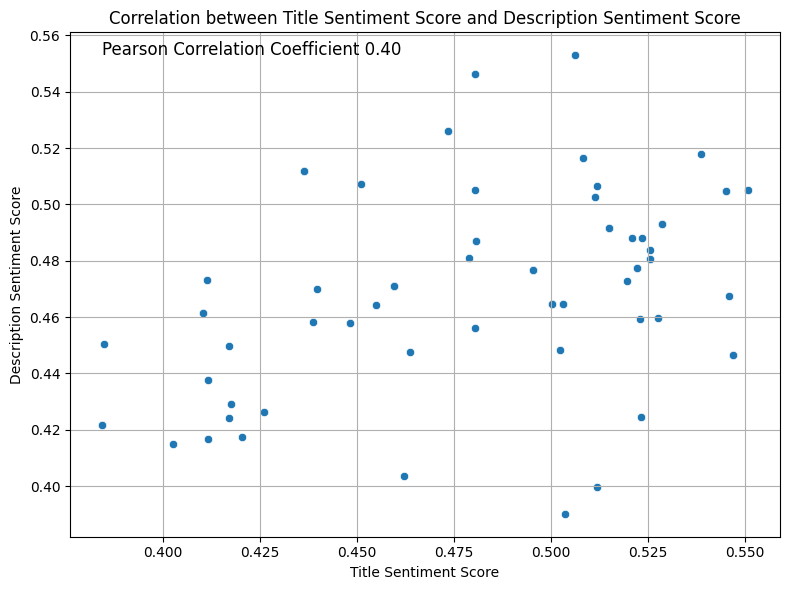

In [17]:
# Creation a correlation plot between title_sentiment_score and description_sentiment_score
x = df['title_sentiment_score']
y = df['description_sentiment_score']

# Compute Pearson correlation
r, _ = pearsonr(x, y)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y)
plt.title('Correlation between Title Sentiment Score and Description Sentiment Score')
plt.text(min(x), max(y), f"Pearson Correlation Coefficient {r:.2f}", fontsize=12)
plt.xlabel('Title Sentiment Score')
plt.ylabel('Description Sentiment Score')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Analyse the distribution of title_sentiment_score and description_sentiment_score
df[['title_sentiment_score','description_sentiment_score']].describe()

,title_sentiment_score,description_sentiment_score
count,95.000000,95.000000
mean,0.488467,0.474849
std,0.044437,0.031553
min,0.384477,0.390182
25%,0.459573,0.459556
50%,0.503269,0.477350
75%,0.525579,0.492888
max,0.550800,0.552954


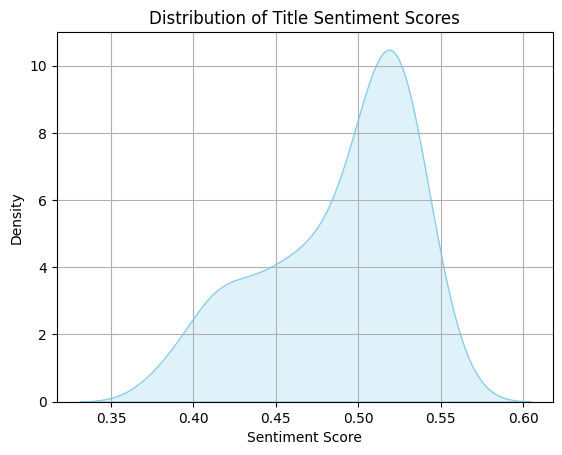

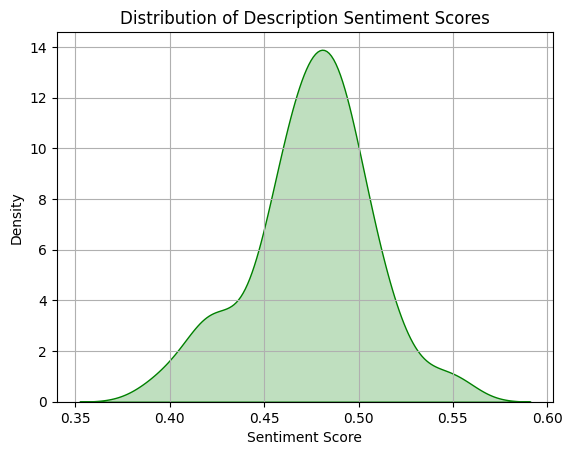

In [19]:
# Title Sentiment Distribution
sns.kdeplot(df['title_sentiment_score'], fill=True, color='skyblue')
plt.title("Distribution of Title Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Density")
plt.grid(True)
plt.show()

# Body Sentiment Distribution
sns.kdeplot(df['description_sentiment_score'], fill=True, color='green')
plt.title("Distribution of Description Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Density")
plt.grid(True)
plt.show()